In [1]:
import os
import sys
sys.path.append('..')
import json
import time
import tqdm
import yaml
import torch
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.distributed as dist
from IPython.display import clear_output
from copy import deepcopy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from libs.model import ECG_Inception, PPG_Inception, EDA_LSTM
from torch.utils.data import DataLoader
from libs.dataloader import SeNSEDataset, BalancedBatchSampler

In [2]:
subject_id = 'c1s01'
version = 'v1'
data_type = 'eda'
config_dir = '../configs'
data_dir = '../data'

In [3]:
with open(f"{config_dir}/{data_type}.yaml", 'r') as f:
    config = yaml.safe_load(f)

In [4]:
print(f"Config: {config}")

Config: {'batch_size': 128, 'lr': 0.0007, 'epochs': 1000, 'patience': 100}


In [5]:
data_path = f'{data_dir}/{subject_id}/{data_type}.pkl'
metadata_path = f'{data_dir}/{subject_id}/metadata.json'
data = pd.read_pickle(data_path)
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

In [6]:
train_data = SeNSEDataset(data, metadata[version]['train'], data_type=data_type, verbose=False)
val_data = SeNSEDataset(data, metadata[version]['val'], data_type=data_type, verbose=False)

train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=False, num_workers=8)
val_loader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=False, num_workers=8)

print(f"Training version {version}")
print("Normal/Hypo ratio: {}".format(train_data.normal_hypo_ratio))

Training version v1
Normal/Hypo ratio: 16.45054945054945


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on device: {}".format(device))
if data_type == 'ecg':
    model = ECG_Inception(normal_hypo_ratio=train_data.normal_hypo_ratio)
elif data_type == 'ppg':
    model = PPG_Inception(normal_hypo_ratio=train_data.normal_hypo_ratio)
elif data_type == 'eda':
    model = EDA_LSTM(normal_hypo_ratio=train_data.normal_hypo_ratio)
else:
    raise ValueError(f"Unknown data type: {data_type}")
model.to(device)

print("Model size: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(config['patience']*0.7), verbose=True)

Training on device: cuda
Model size: 1525


/mnt/nvme-data1/mtseng/miniconda3/envs/ecg/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


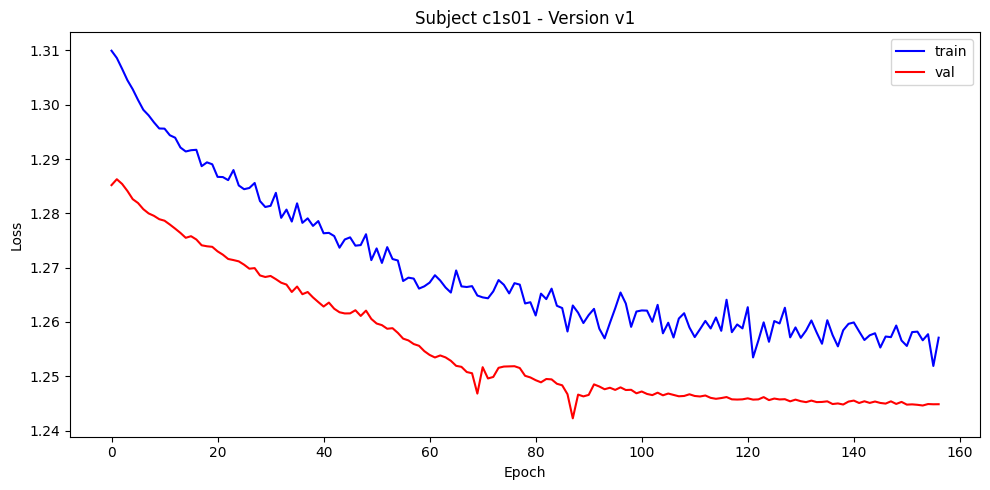

In [ ]:
# training
best_loss = 1e9
training_losses = []
validating_losses = []
saved_epoch = 0
early_stopping = 0
best_model = None
for epoch in range(config['epochs']):
    model.train()
    training_loss = 0
    train_data.stratified_sampling(batch_size=config['batch_size'])

    start_t = time.time()
    
    num_batches = len(train_loader)
    for i, (signal_data, hypo_label, glucose, cgm_idx) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        if data_type == 'eda':
            phasic, tonic = signal_data
            phasic, tonic, hypo_label, glucose = phasic.float().to(device), tonic.float().to(device), hypo_label.float().to(device), glucose.float().to(device)
            pred_label = model(phasic, tonic)
            num_data = phasic.shape[0]
            if phasic.shape[0] == 1:
                pred_label = pred_label.unsqueeze(0)
        else:
            signal_data, hypo_label, glucose = signal_data.float().to(device), hypo_label.float().to(device), glucose.float().to(device)
            pred_label = model(signal_data)
            num_data = signal_data.shape[0]
            if signal_data.shape[0] == 1:
                pred_label = pred_label.unsqueeze(0)
        loss = model.loss(pred_label, hypo_label, weighted=True)
        loss.backward()
        optimizer.step()
        training_loss += (loss.item() * num_data)

    
    training_loss = training_loss / len(train_loader.dataset)

    model.eval()
    validating_loss = 0
    with torch.no_grad():
        for signal_data, hypo_label, glucose, cgm_idx in val_loader:
            if data_type == 'eda':
                phasic, tonic = signal_data
                phasic, tonic, hypo_label, glucose = phasic.float().to(device), tonic.float().to(device), hypo_label.float().to(device), glucose.float().to(device)
                pred_label = model(phasic, tonic)
                num_data = phasic.shape[0]
                if phasic.shape[0] == 1:
                    pred_label = pred_label.unsqueeze(0)
            else:
                signal_data, hypo_label, glucose = signal_data.float().to(device), hypo_label.float().to(device), glucose.float().to(device)
                pred_label = model(signal_data)
                num_data = signal_data.shape[0]
                if signal_data.shape[0] == 1:
                    pred_label = pred_label.unsqueeze(0)
            loss = model.loss(pred_label, hypo_label, weighted=True)
            validating_loss += (loss.item() * num_data)

    validating_loss = validating_loss / len(val_loader.dataset)

    print(f"epoch: {epoch}| training_loss: {training_loss:.4f}| validating_loss: {validating_loss:.4f}| time: {time.time()-start_t:.2f}s")

    # Track the best model
    if validating_loss < best_loss:
        best_loss = validating_loss
        best_model = deepcopy(model)
        saved_epoch = epoch
        early_stopping = 0
    else:
        early_stopping += 1

    scheduler.step(validating_loss)


    training_losses.append(training_loss)
    validating_losses.append(validating_loss)

    # Plot the training and validating losses
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='train', color='blue')
    plt.plot(validating_losses, label='val', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Subject {} - Version {}'.format(subject_id, version))
    plt.tight_layout()
    plt.show()

    # Broadcast early stopping signal
    require_early_stop = early_stopping >= config['patience']
    if require_early_stop:
        print(f"Early stopping at epoch {epoch}")
        break
